# Simulations

## Outline

<ol>
  <li>Import our test set with mean predictions and best Poisson model that we trained in cross_validation.ipynb.</li>
  <li>Run bootstrapping to generate confidence and prediction intervals that provide us with a sense of uncertainty around our model's estimates.</li>
  <li>Compute the full probability distribution for each test set observation given our mean predictions.</li>
  <li>Generate a visualization showing the results of bootstrapping.</li>
</ol>

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd
import polars as pl
import datetime
import sys
import os

# Regression
from sklearn.linear_model import PoissonRegressor

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Utilities
import os
os.chdir('<YOUR_ROOT_DIRECTORY>') # navigate to the root

from utils.nfl_utils import plot_prediction_interval

# Loading model
import skops.io as sio

pl.Config(tbl_cols = 50, tbl_rows = 60, set_fmt_str_lengths = 150)

In [ ]:
# Import our model and data needed for bootstrapping.
unknown_types = sio.get_untrusted_types(file='<YOUR_MODELS_DIRECTORY>/qb_poisson_model.skops')
qb_poisson_model = sio.load('<YOUR_MODELS_DIRECTORY>/qb_poisson_model.skops', trusted=unknown_types)

y_test_all = pd.read_parquet('<YOUR_DATASETS_DIRECTORY>/qb_test_true_pred.parquet')
X_train = pd.read_parquet('<YOUR_DATASETS_DIRECTORY>/qb_X_train.parquet')
X_test = pd.read_parquet('<YOUR_DATASETS_DIRECTORY>/qb_X_test.parquet')

y_test_all.tail()

,season,week,player_display_name,team,defteam,y_true,y_pred
4290,2024,21,Patrick Mahomes,KC,BUF,1,1.699485
4291,2024,21,Jalen Hurts,PHI,WAS,1,1.617485
4292,2024,21,Jayden Daniels,WAS,PHI,1,1.248563
4293,2024,22,Patrick Mahomes,KC,PHI,3,1.711062
4294,2024,22,Jalen Hurts,PHI,KC,2,1.581912


In [4]:
# Let's obtain confidence intervals for lambda and prediction intervals for actual counts. We'll use bootstrapping.

# Here is the setup.
n_boot = 10000
n_train = X_train.shape[0]
n_test = X_test.shape[0]

lambda_bootstrap = np.zeros((n_test, n_boot))
y_pred_bootstrap = np.zeros((n_test, n_boot))

# For reproducability.
rng = np.random.default_rng(42)

for sim in range(n_boot):

    # Simulate new counts, refit, and then store the new predictions
    y_pred_train = qb_poisson_model.predict(X_train)
    y_sim = rng.poisson(lam=y_pred_train, size=n_train)

    sim_poisson = PoissonRegressor(alpha=0.1, max_iter=100, solver='newton-cholesky')
    sim_poisson.fit(X_train, y_sim)

    sim_y_pred = sim_poisson.predict(X_test)
    lambda_bootstrap[:, sim] = sim_y_pred

    y_pred_bootstrap[:, sim] = rng.poisson(lam=sim_y_pred, size=n_test)

In [5]:
# Convert y_test_all to a Polars dataframe.
y_test_all = pl.from_pandas(y_test_all)

# Compute confidence intervals and prediction intervals.
lower_ci = np.percentile(lambda_bootstrap, 2.5, axis=1)
upper_ci = np.percentile(lambda_bootstrap, 97.5, axis=1)

pred_lower_ci = np.percentile(y_pred_bootstrap, 2.5, axis=1)
pred_upper_ci = np.percentile(y_pred_bootstrap, 97.5, axis=1)

# Combine the results.
y_test_all_results = (
    y_test_all
    .with_columns(
        pl.Series('ci_lower', lower_ci),
        pl.Series('ci_upper', upper_ci),
        pl.Series('pred_lower_ci', pred_lower_ci),
        pl.Series('pred_upper_ci', pred_upper_ci),
        pl.Series('y_pred_bootstrap', y_pred_bootstrap)
    )
)

y_test_all_results.tail()

season,week,player_display_name,team,defteam,y_true,y_pred,ci_lower,ci_upper,pred_lower_ci,pred_upper_ci,y_pred_bootstrap
i32,i32,str,str,str,i32,f64,f64,f64,f64,f64,"array[f64, 10000]"
2024,21,"""Patrick Mahomes""","""KC""","""BUF""",1,1.699485,1.622257,1.75253,0.0,5.0,"[0.0, 0.0, … 2.0]"
2024,21,"""Jalen Hurts""","""PHI""","""WAS""",1,1.617485,1.560929,1.767897,0.0,5.0,"[2.0, 2.0, … 2.0]"
2024,21,"""Jayden Daniels""","""WAS""","""PHI""",1,1.248563,1.175268,1.385334,0.0,4.0,"[2.0, 1.0, … 0.0]"
2024,22,"""Patrick Mahomes""","""KC""","""PHI""",3,1.711062,1.639642,1.792861,0.0,5.0,"[4.0, 0.0, … 3.0]"
2024,22,"""Jalen Hurts""","""PHI""","""KC""",2,1.581912,1.513642,1.694566,0.0,4.0,"[2.0, 1.0, … 2.0]"


In [ ]:
# Now let's calculate the probability for each count. The largest count (4) will be calculated as the probability of 4+.
td_range = np.unique(y_test_all_results.select('y_true').to_numpy())
k_max = td_range[-1]

# Get all of the lambdas.
lambda_series = y_test_all_results['y_pred'].to_numpy()

for k in td_range:
    if k < k_max:
        probs = poisson.pmf(k, lambda_series)
        col_name = f'p_{k}_td'
    else:
        # The last bin is 1 - the cumulative sum of prior count probabilities
        probs = 1 - poisson.cdf(k_max - 1, lambda_series)
        col_name = f'p_{k}plus_td'
    
    y_test_all_results = (
        y_test_all_results
        .with_columns(
        pl.Series(col_name, probs)
        )
    )

y_test_all_results.tail()

season,week,player_display_name,team,defteam,y_true,y_pred,ci_lower,ci_upper,pred_lower_ci,pred_upper_ci,y_pred_bootstrap,p_0_td,p_1_td,p_2_td,p_3_td,p_4plus_td
i32,i32,str,str,str,i32,f64,f64,f64,f64,f64,"array[f64, 10000]",f64,f64,f64,f64,f64
2024,21,"""Patrick Mahomes""","""KC""","""BUF""",1,1.699485,1.622257,1.75253,0.0,5.0,"[0.0, 0.0, … 2.0]",0.182778,0.310628,0.263954,0.149528,0.093112
2024,21,"""Jalen Hurts""","""PHI""","""WAS""",1,1.617485,1.560929,1.767897,0.0,5.0,"[2.0, 2.0, … 2.0]",0.198397,0.320904,0.259529,0.139928,0.081242
2024,21,"""Jayden Daniels""","""WAS""","""PHI""",1,1.248563,1.175268,1.385334,0.0,4.0,"[2.0, 1.0, … 0.0]",0.286917,0.358234,0.223639,0.093076,0.038135
2024,22,"""Patrick Mahomes""","""KC""","""PHI""",3,1.711062,1.639642,1.792861,0.0,5.0,"[4.0, 0.0, … 3.0]",0.180674,0.309144,0.264482,0.150849,0.094851
2024,22,"""Jalen Hurts""","""PHI""","""KC""",2,1.581912,1.513642,1.694566,0.0,4.0,"[2.0, 1.0, … 2.0]",0.205582,0.325212,0.257228,0.135638,0.07634


### We can visualize the probable range of outcomes for a QB in any game of our choice.

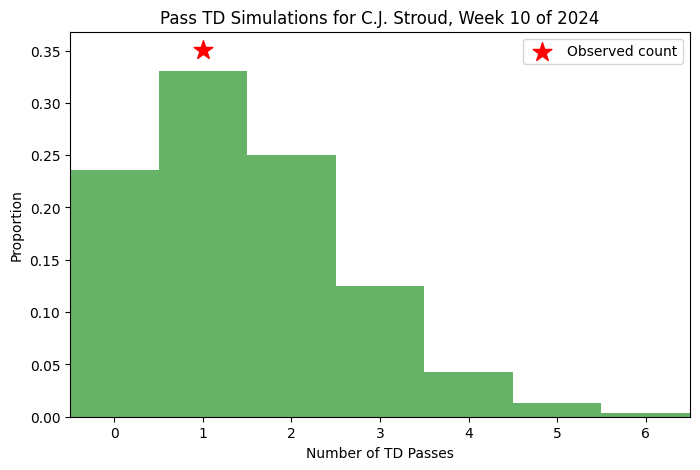

In [7]:
# Let's plot our results. Here is an example.
plot_prediction_interval(y_test_all_results, 'HOU', 2024, 10)

In [ ]:
# Export.
y_test_all_results.write_parquet('<YOUR_DATASETS_DIRECTORY>/qb_bootstrap_results.parquet')